In [1]:
import xarray as xr
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

from functions import masked_average

In [2]:
import cartopy.crs as ccrs
import cartopy as cy
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl = ax.gridlines()#draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False


In [3]:
import matplotlib.path as mpath

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)


In [4]:
os.getcwd()

'/home/jonahks/git_repos/netcdf_analysis'

Grab CALIOP data first

In [75]:
os.chdir('/home/jonahks/drivemount/caliop_slfs/')
files = os.listdir()
files

['MPC_CALIOP_90-70N.dat',
 'MPC_CALIOP_10N-10S.dat',
 'MPC_CALIOP_10-30S.dat',
 'MPC_CALIOP_50-70S.dat',
 'MPC_CALIOP_50-30N.dat',
 'MPC_CALIOP_70-50N.dat',
 'MPC_CALIOP_70-90S.dat',
 'MPC_CALIOP_30-50S.dat',
 'MPC_CALIOP_30-10N.dat']

In [82]:
caliop_arc = pd.read_table('MPC_CALIOP_90-70N.dat', sep="\s+", names=['Isotherm', 'SLF'])
caliop_arc['Isotherm']

0   -40
1   -30
2   -20
3   -10
4     0
Name: Isotherm, dtype: int64

In [6]:
#mnth15runs/20191122_161009_sample_param_set_wbf1_inp1
os.chdir('/home/jonahks/drivemount/mnth15runs/20191122_161009_sample_param_set_wbf1_inp1/')
files = os.listdir()
files

['20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-12.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0002-02.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-08.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-06.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-03.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-05.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0002-03.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-07.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.i.0002-01-01-00000.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-09.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-04.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-10.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0002-01.nc',
 '20191122_161009_sample_param_set_wbf1_inp1.cam.h0.0001-11.nc',
 '20191122_161009_sample_param_s

In [7]:
ds = xr.open_dataset('20191122_161009_sample_param_set_wbf1_inp1.nc')
#ds = xr.open_dataset(files[0])
gw = ds['gw']

Create new variable by dividing out the cloud fraction near each isotherm

In [9]:
ds['SLF_ISOTM'] = ds['SLFXCLD_ISOTM'] / ds['CLD_ISOTM']

In [30]:
print(ds['SLF_ISOTM'].shape) 

(15, 9, 96, 144)


Select dates after a 3 month wind-up

In [54]:
slf_isotm = ds['SLF_ISOTM'].sel(time=slice('0001-04-01', '0002-03-01'))
ds['SLF_ISOTM_AVG'] = slf_isotm.mean(dim = 'time', skipna=True)

In [56]:
slf_isotm = ds['SLF_ISOTM_AVG']

Plot the global SLF at each isotherm

Text(0.5, 0.98, 'SLF distribution across isotherms')

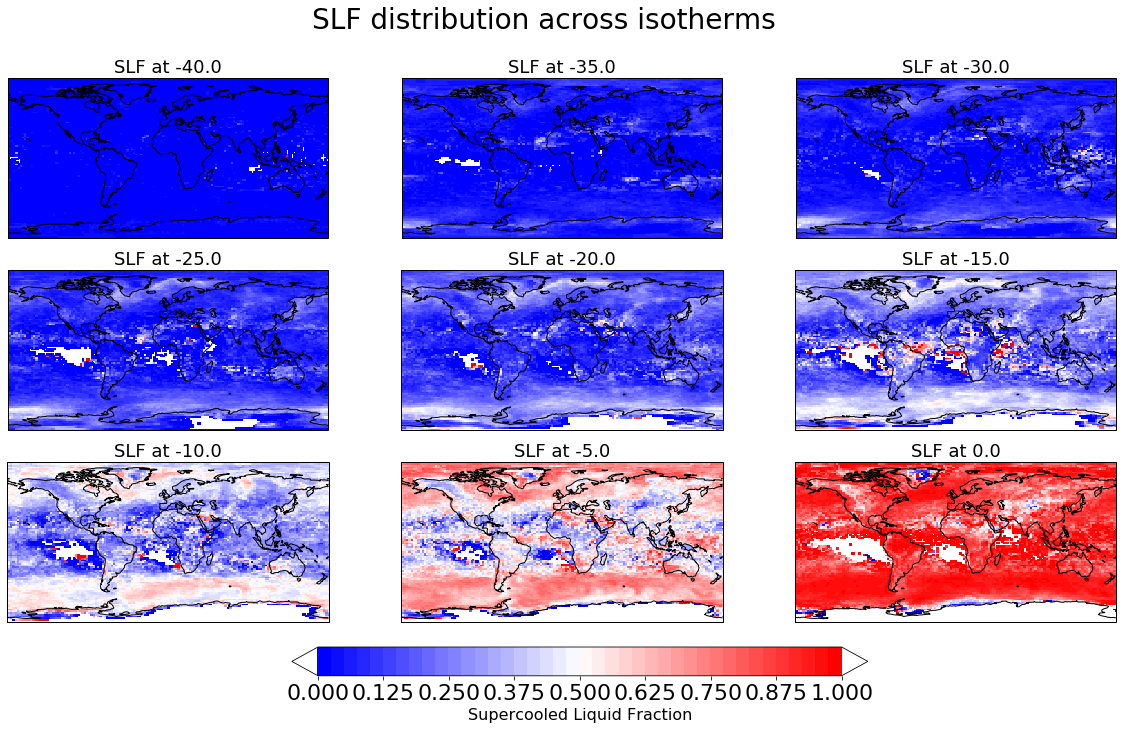

In [57]:
fig1, axes1 = plt.subplots(nrows=3,ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[20,10]);

cmin_p = np.nanmin(slf_isotm)
cmax_p = np.nanmax(slf_isotm)

cmap_p = 'bwr'
nlevels = 41
cmap2 = plt.get_cmap(cmap_p)

if cmin_p == cmax_p:
   cmax_p = cmax_p + 0.00001

levels = np.linspace(cmin_p,cmax_p,nlevels)

for data, ax in zip(slf_isotm, axes1.flatten()):
    iso = data['isotherms_mpc'].values - 273.15
    map = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr', robust=True, add_colorbar = False, levels=levels)

    ax.set_title('SLF at %s' % str(iso), fontsize=18)
    ax.coastlines()
cb_ax = fig1.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=22)
cbar.ax.set_xlabel('Supercooled Liquid Fraction', fontsize=16)

fig1.suptitle('SLF distribution across isotherms', fontsize=28)

In [58]:
_wgs = ds['TS'].copy()
_wgs = (_wgs * 0 + 1) * gw # copy gw into the 2d array
_wgs = _wgs / np.sum(_wgs)  # Normalize
_wgs.name = 'cell_weight'

ds['cell_weight'] = _wgs

In [59]:
np.nansum(np.multiply(ds['TS'], ds['cell_weight']))

287.9706401538431

In [60]:
glob_mean = masked_average(ds['TS'], dim=['lat','lon'], weights=ds['cell_weight'])
glob_mean

<xarray.DataArray (time: 15)>
array([286.05912221, 286.3412451 , 286.96884867, 288.2678944 ,
       289.10333084, 289.73145603, 290.07454746, 290.21377769,
       289.62472152, 288.63197373, 287.55437371, 286.78242016,
       286.30969949, 286.58615426, 287.31003704])
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0002-04-01 00:00:00

In [61]:
mask = np.bitwise_or(ds['lat']<70, ds['lat']>90)

In [70]:
glob_slf_trend = []
arc_slf_trend = []
for data in slf_isotm:
    arc_mean = masked_average(data, dim=['lat','lon'], weights=ds['cell_weight'], mask=mask)
    glob_mean = masked_average(data, dim=['lat','lon'], weights=ds['cell_weight'])
    iso = data['isotherms_mpc'].values - 273.15
    slf = arc_mean.values[0]*100
    slf2 = glob_mean.values[0]*100
    print('SLF at %s is ' % str(iso), slf)
    arc_slf_trend.append([iso, slf])
    glob_slf_trend.append([iso, slf2])
arc_slf_trend = np.transpose(arc_slf_trend)
glob_slf_trend = np.transpose(glob_slf_trend)

SLF at -40.0 is  0.5616194389781489
SLF at -35.0 is  7.450646799664179
SLF at -30.0 is  8.948410228827235
SLF at -25.0 is  12.320967587077423
SLF at -20.0 is  20.70925097036171
SLF at -15.0 is  32.392769621032066
SLF at -10.0 is  46.99969184039775
SLF at -5.0 is  67.80058221313752
SLF at 0.0 is  84.65056139559708


In [71]:
arc_slf_trend
glob_slf_trend

array([[-40.        , -35.        , -30.        , -25.        ,
        -20.        , -15.        , -10.        ,  -5.        ,
          0.        ],
       [  0.7146115 ,   4.39448574,   7.02352496,  10.57954298,
         15.56277488,  26.99827511,  35.23254132,  53.40229636,
         86.67281907]])

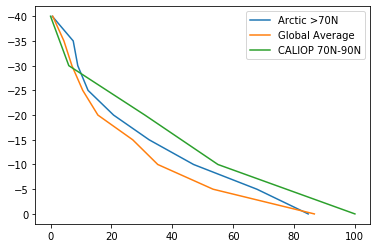

In [86]:
plt.gca().invert_yaxis()
plt.plot(arc_slf_trend[1], arc_slf_trend[0], label='Arctic >70N')
plt.plot(glob_slf_trend[1], glob_slf_trend[0], label='Global Average')
plt.plot(caliop_arc['SLF'], caliop_arc['Isotherm'], label='CALIOP 70N-90N')
plt.legend()

In [87]:
for i in caliop_arc['Isotherm']:
    print(i)

-40
-30
-20
-10
0


In [75]:
os.chdir('/home/jonahks/drivemount/caliop_slfs/')
files = os.listdir()
files

['MPC_CALIOP_90-70N.dat',
 'MPC_CALIOP_10N-10S.dat',
 'MPC_CALIOP_10-30S.dat',
 'MPC_CALIOP_50-70S.dat',
 'MPC_CALIOP_50-30N.dat',
 'MPC_CALIOP_70-50N.dat',
 'MPC_CALIOP_70-90S.dat',
 'MPC_CALIOP_30-50S.dat',
 'MPC_CALIOP_30-10N.dat']

In [82]:
caliop_arc = pd.read_table('MPC_CALIOP_90-70N.dat', sep="\s+", names=['Isotherm', 'SLF'])
caliop_arc['Isotherm']

0   -40
1   -30
2   -20
3   -10
4     0
Name: Isotherm, dtype: int64

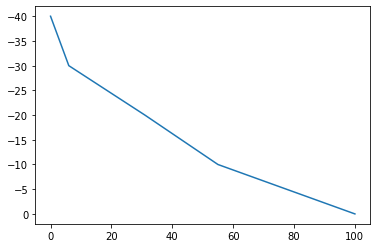

In [85]:
plt.gca().invert_yaxis()
plt.plot(caliop_arc['SLF'], caliop_arc['Isotherm'])

In [199]:
for data in slf_isotm:
    arc_mean = masked_average(data, dim=['lat','lon'], weights=ds['cell_weight'])
    iso = data['isotherms_mpc'].values - 273.15
    print('SLF at %s is ' % str(iso), arc_mean.values*100)

SLF at -40.0 is  [1.19741687]
SLF at -35.0 is  [6.37842616]
SLF at -30.0 is  [8.69901934]
SLF at -25.0 is  [13.11064629]
SLF at -20.0 is  [18.50281827]
SLF at -15.0 is  [29.34061534]
SLF at -10.0 is  [38.43012017]
SLF at -5.0 is  [54.78347867]
SLF at 0.0 is  [87.41093273]


In [201]:
slf_isotm['isotherms_mpc'].values

array([233.15, 238.15, 243.15, 248.15, 253.15, 258.15, 263.15, 268.15,
       273.15])

In [189]:
glob_mean = masked_average(ds['TS'], dim=['lat','lon'], weights=ds['cell_weight'], mask=mask)
glob_mean

<xarray.DataArray (time: 1)>
array([242.26836806])
Coordinates:
  * time     (time) object 0001-02-01 00:00:00

In [33]:
cld_prox = ds['CLOUD'].isel(time=0, lev=15)

In [35]:
print(gw.shape, cld_prox.shape)
np.multiply(cld_prox, gw)

(96,) (96, 144)


<xarray.DataArray (lat: 96, lon: 144)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90959251e-09, 1.97852894e-09, 1.44073494e-09, ...,
        2.98357571e-09, 2.09623482e-09, 1.81677796e-09],
       ...,
       [1.17454014e-04, 1.20864543e-04, 1.23258007e-04, ...,
        1.03748256e-04, 1.08351560e-04, 1.12481361e-04],
       [4.63128310e-05, 4.64023717e-05, 4.63627007e-05, ...,
        3.50654959e-05, 4.11605636e-05, 4.62547298e-05],
       [2.75256688e-06, 2.75256688e-06, 2.75256688e-06, ...,
        2.75256688e-06, 2.75256688e-06, 2.75256688e-06]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lev      float64 232.8
    time     object 0001-02-01 00:00:00